In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from typing import Sequence
from numpy.typing import NDArray

np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [2]:
# def append_ones(matrix):
#     return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=1)


def zeros(*dims: int) -> NDArray:
    return np.zeros(shape=tuple(dims), dtype=np.float32)


def ones(*dims: int) -> NDArray:
    return np.ones(shape=tuple(dims), dtype=np.float32)


def rand(*dims: int) -> NDArray:
    return np.random.rand(*dims).astype(np.float32)


def chunks(seq: NDArray, size: int):
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def tiles(examples: NDArray):
    space = 2
    rows, cols, h, w = examples.shape

    img_matrix = np.empty(shape=(rows * (h + space) - space, cols * (h + space) - space))
    img_matrix.fill(np.nan)

    for r in range(rows):
        for c in range(cols):
            x_0 = r * (h + space)
            y_0 = c * (w + space)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0 : x_0 + h, y_0 : y_0 + w] = (examples[r, c] - ex_min) / (ex_max - ex_min)

    plt.matshow(img_matrix, cmap="gray", interpolation="none")
    plt.axis("off")
    plt.show()

# MNIST dataset

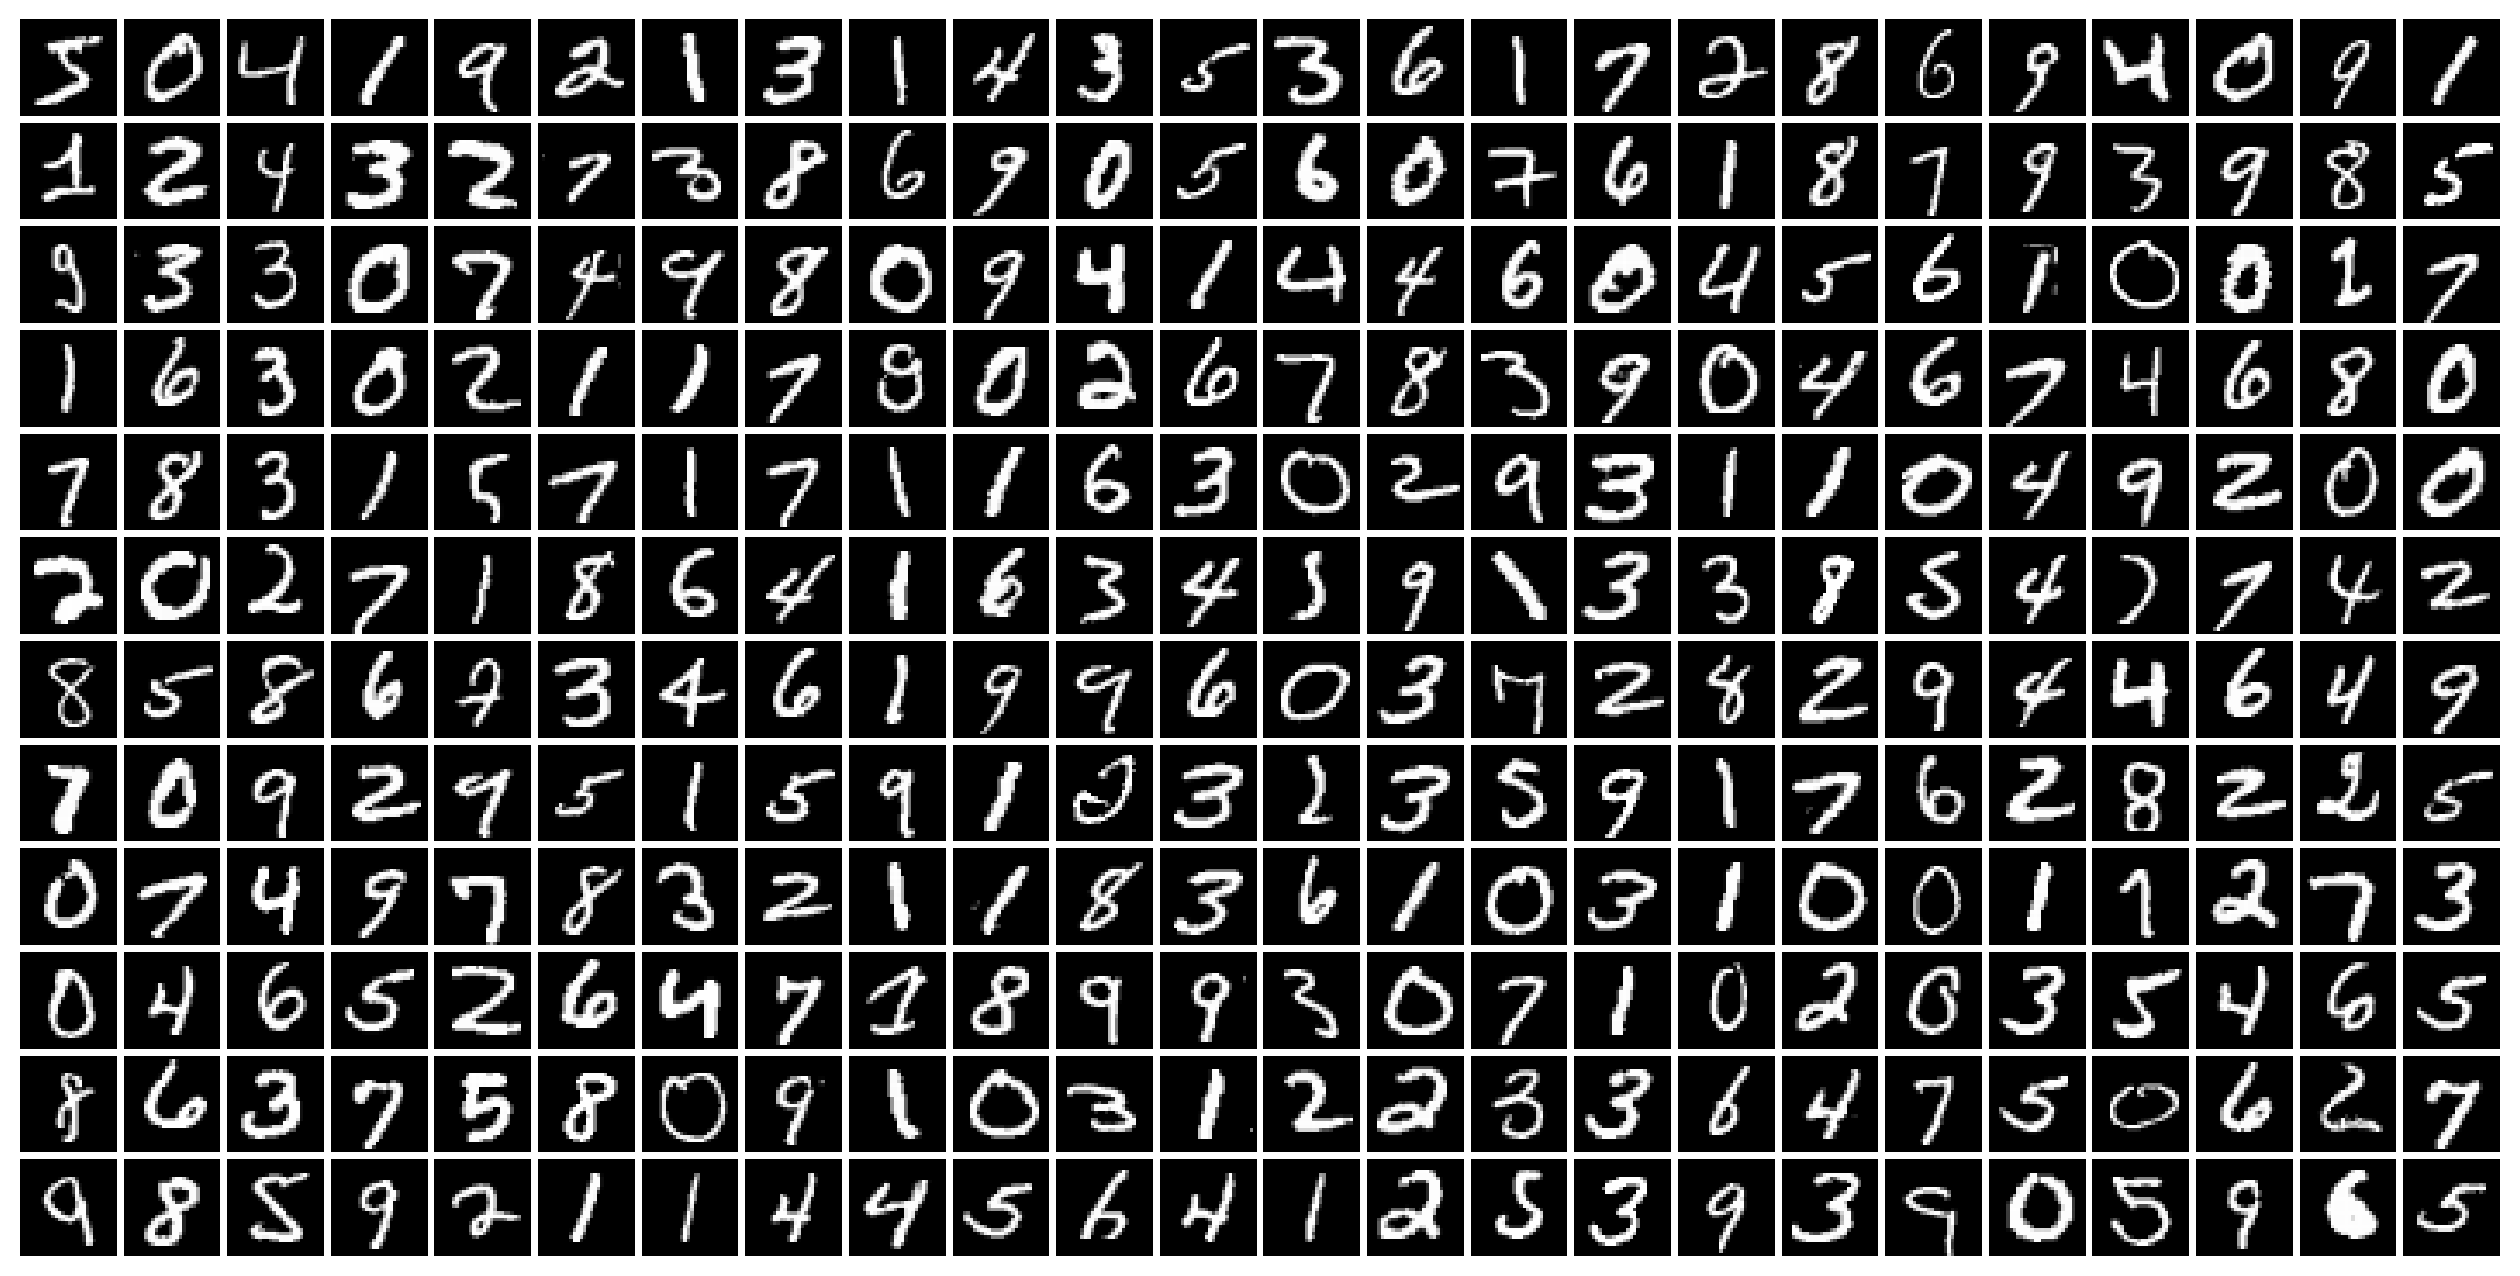

In [3]:
from mnists import MNIST

mnist = MNIST()
digits = mnist.train_images()
digits = digits[: 12 * 24]
digits = digits.reshape(-1, 24, 28, 28)
tiles(digits)

# Restricted Boltzmann Machine & Contrastive Divergence algorithm

In [4]:
def sigmoid(x: NDArray) -> NDArray:
    return 1.0 / (1.0 + np.exp(-x))


class RBM:
    def __init__(self, vsize: int, hsize: int, lr: float, momentum: float):
        # Variables' sizes
        self.vsize = vsize
        self.hsize = hsize
        # Training hyper-params
        self.lr = lr
        self.momentum = momentum
        # Initialize
        self.reset()

    def reset(self):
        # Xavier initialization
        scale = np.sqrt(6 / (self.vsize + self.hsize))
        self.w = np.random.uniform(-scale, +scale, size=(self.vsize, self.hsize)).astype(np.float32)

        # Zero initialization
        self.b = zeros(self.vsize)
        self.c = zeros(self.hsize)

        # Velocity (momentum) tensor initialization
        self.m_w = zeros(self.vsize, self.hsize)
        self.m_b = zeros(self.vsize)
        self.m_c = zeros(self.hsize)

    def probas_v(self, h: NDArray) -> NDArray:
        return sigmoid(self.b + h @ self.w.T)

    def probas_h(self, v: NDArray) -> NDArray:
        return sigmoid(self.c + v @ self.w)

    def sample(self, v: NDArray, steps: int) -> NDArray:
        batch_size = v.shape[0]
        # --- Gibbs sampling
        for k in range(steps):
            h = self.probas_h(v) > rand(batch_size, self.hsize)
            σ = self.probas_v(h)
            if k < steps - 1:
                v = σ > rand(batch_size, self.vsize)

        return σ

In [5]:
def reconstuction_error(rbm: RBM, v: NDArray) -> float:
    batch_size = v.shape[0]
    σ = rbm.sample(v, steps=1)
    return 1 / batch_size * np.sum((v - σ) ** 2)

In [6]:
def draw_filters(rbm: RBM):
    filters = rbm.w.T
    filters = filters.reshape(8, -1, 28, 28)
    filters = np.clip(filters, -1, 1)
    tiles(filters)

# 1. RBM Training with momentum

In [7]:
def cdk(rbm: RBM, minibatch: NDArray, k: int = 1):
    batch_size = minibatch.shape[0]
    v = minibatch

    # Compute gradients
    # -----------------

    # Positive phase
    σ = rbm.probas_h(v)

    grad_w = -1 / batch_size * (v.T @ σ)
    grad_b = -1 / batch_size * (v.sum(axis=0))
    grad_c = -1 / batch_size * (σ.sum(axis=0))

    # Negative phase

    # --- Gibbs sampling
    h = σ > rand(batch_size, rbm.hsize)
    v = rbm.probas_v(h) > rand(batch_size, rbm.vsize)
    for _ in range(k - 1):
        h = rbm.probas_h(v) > rand(batch_size, rbm.hsize)
        v = rbm.probas_v(h) > rand(batch_size, rbm.vsize)

    # --- Negative gradient estimation
    σ = rbm.probas_h(v)

    grad_w += 1 / batch_size * (v.T @ σ)
    grad_b += 1 / batch_size * (v.sum(axis=0))
    grad_c += 1 / batch_size * (σ.sum(axis=0))

    # Update params
    # -------------
    rbm.m_w = rbm.momentum * rbm.m_w - rbm.lr * grad_w
    rbm.m_b = rbm.momentum * rbm.m_b - rbm.lr * grad_b
    rbm.m_c = rbm.momentum * rbm.m_c - rbm.lr * grad_c

    rbm.w += rbm.m_w
    rbm.b += rbm.m_b
    rbm.c += rbm.m_c

In [8]:
def train_epoch(rbm: RBM, dataset: NDArray, batch_size: int):
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(rbm, batch)
        if batch_idx % round(batches_limit / 50) == 0:
            print("#", end="")


def run_training(rbm: RBM, dataset: NDArray, monitoring_set: NDArray, batch_size: int, epochs_count: int):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch), end="\t")

        if epoch == 5:
            rbm.momentum = 0.8

        start_time = time.time()
        train_epoch(rbm, dataset, batch_size)
        elapsed = time.time() - start_time

        error = reconstuction_error(rbm, monitoring_set)
        print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

    print("Training finished!")

In [9]:
DATASET_SIZE = 20_000  # 60000 for whole dataset
DIGIT_SIZE = 28

VISIBLE_LAYER_SIZE = DIGIT_SIZE * DIGIT_SIZE
HIDDEN_LAYER_SIZE = 128

mnist_train = mnist.train_images().astype(np.float32) / 255.0
np.random.shuffle(mnist_train)
dataset = mnist_train[:DATASET_SIZE]
dataset = dataset.reshape(DATASET_SIZE, DIGIT_SIZE * DIGIT_SIZE)
# dataset = append_ones(dataset)

monitoring_indeces = np.random.choice(DATASET_SIZE, 256, replace=False)
monitoring_set = dataset[monitoring_indeces]

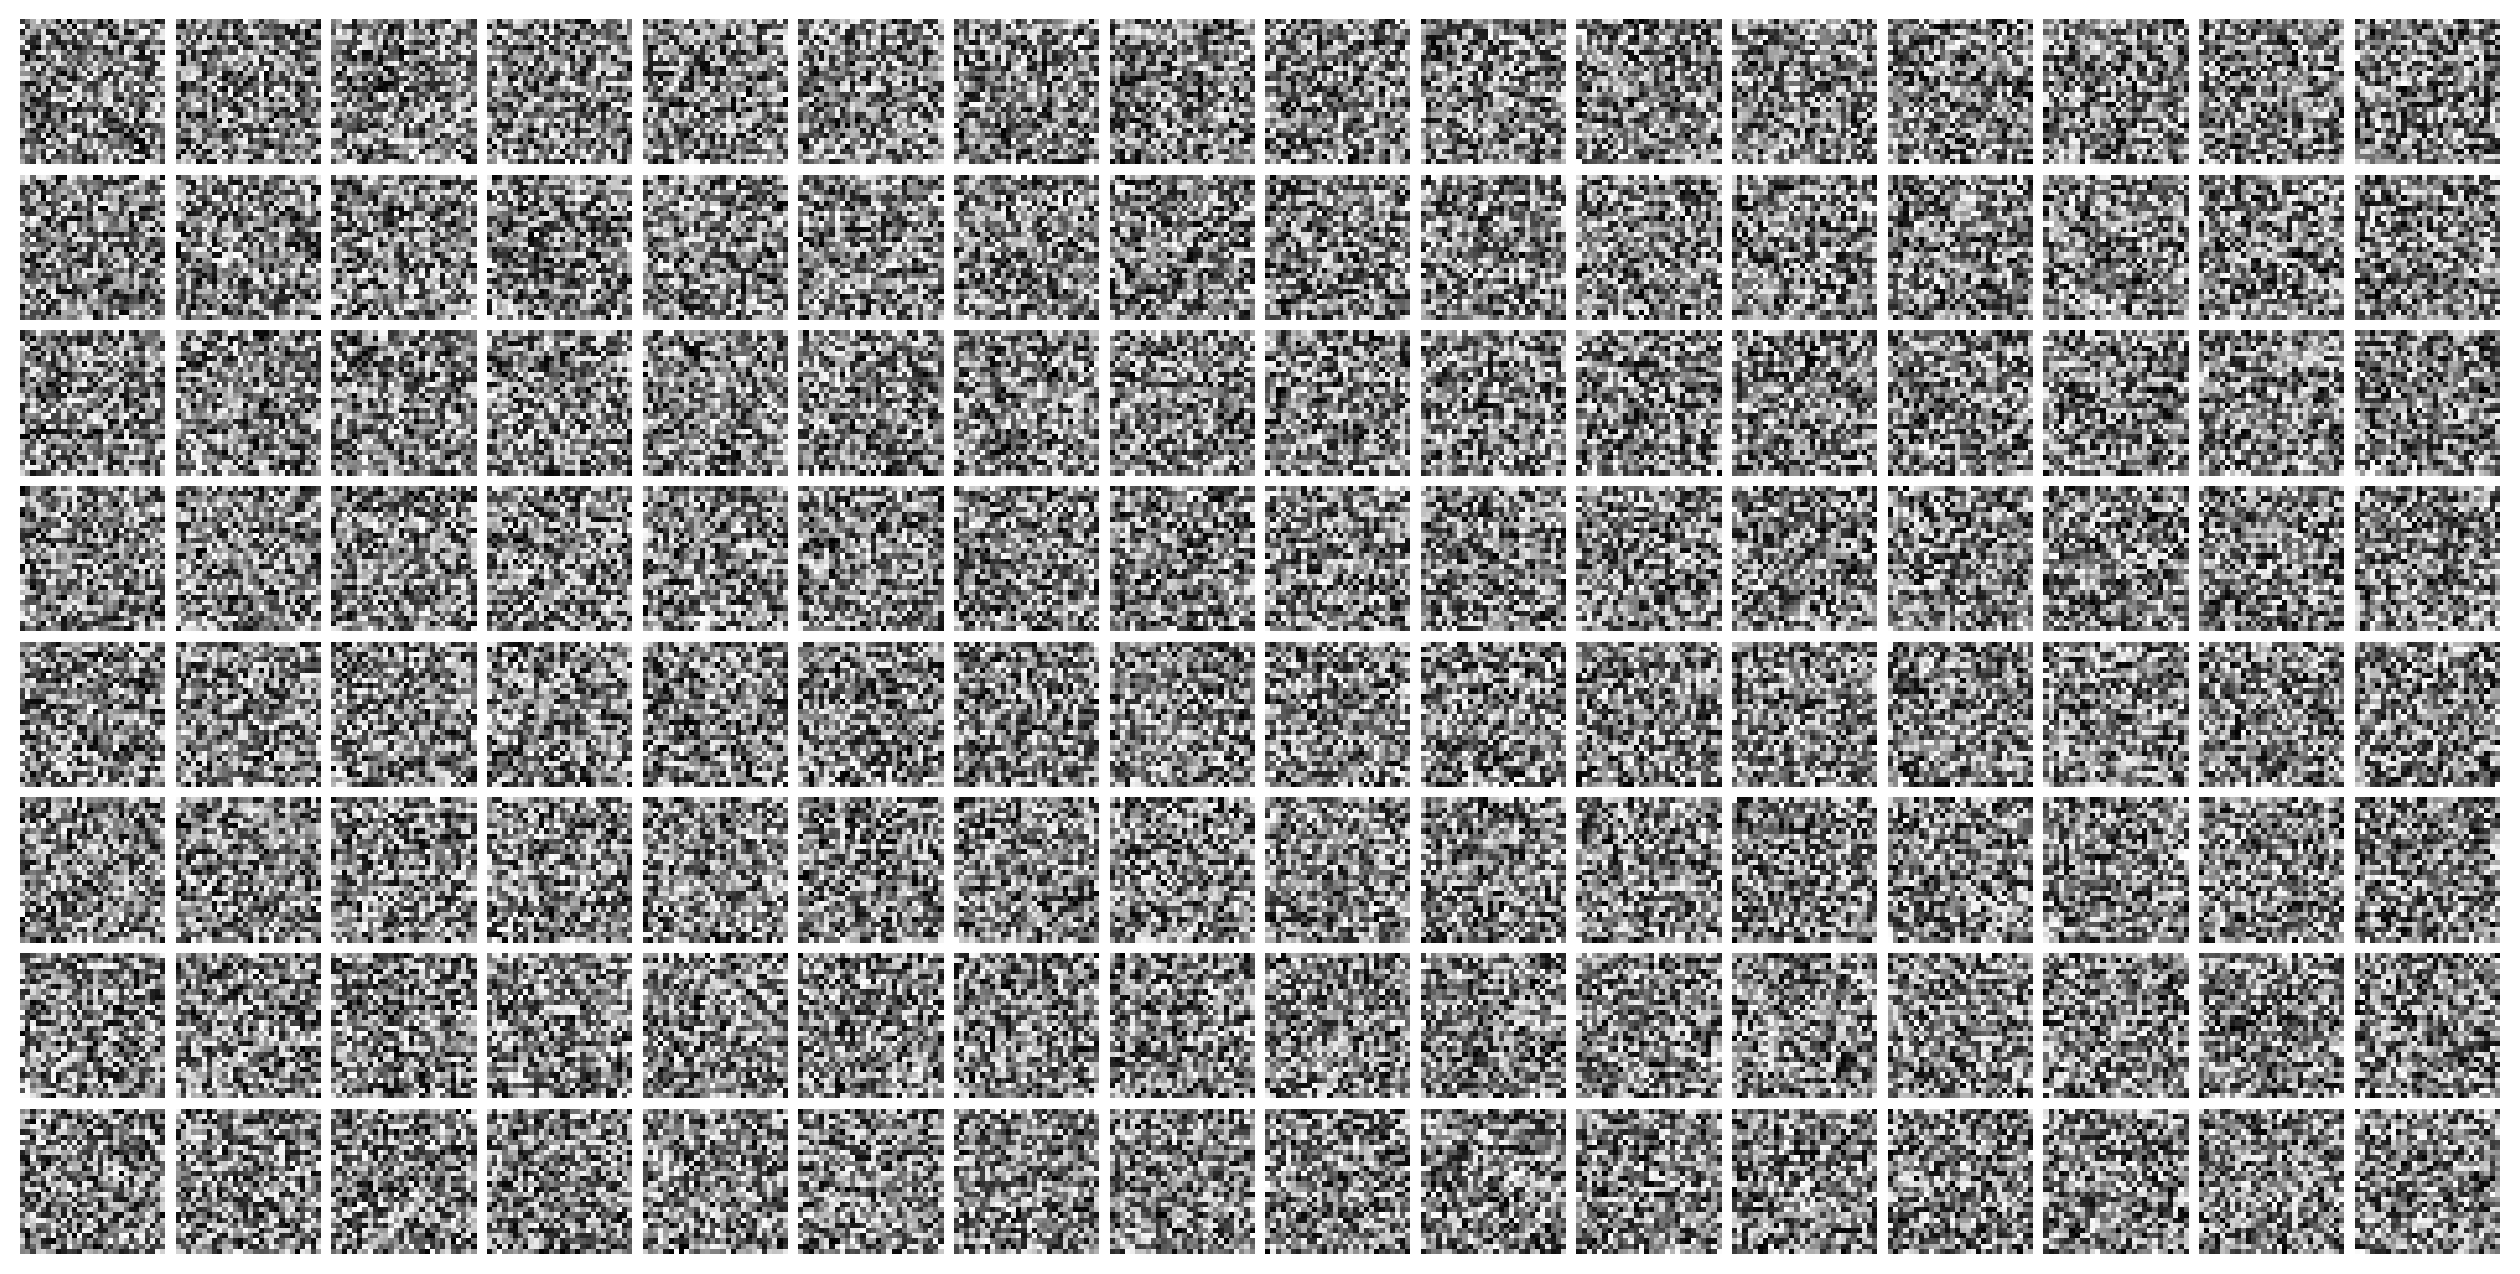

Epoch 0:	#####################################################	elapsed: 0.72s, reconstruction error: 24.16
Epoch 1:	#####################################################	elapsed: 0.27s, reconstruction error: 19.89
Epoch 2:	#####################################################	elapsed: 0.45s, reconstruction error: 18.04
Epoch 3:	#####################################################	elapsed: 0.45s, reconstruction error: 16.95
Epoch 4:	#####################################################	elapsed: 0.53s, reconstruction error: 15.74
Epoch 5:	#####################################################	elapsed: 0.39s, reconstruction error: 14.79
Epoch 6:	#####################################################	elapsed: 0.41s, reconstruction error: 13.91
Epoch 7:	#####################################################	elapsed: 0.44s, reconstruction error: 13.07
Epoch 8:	#####################################################	elapsed: 0.42s, reconstruction error: 12.57
Epoch 9:	############################

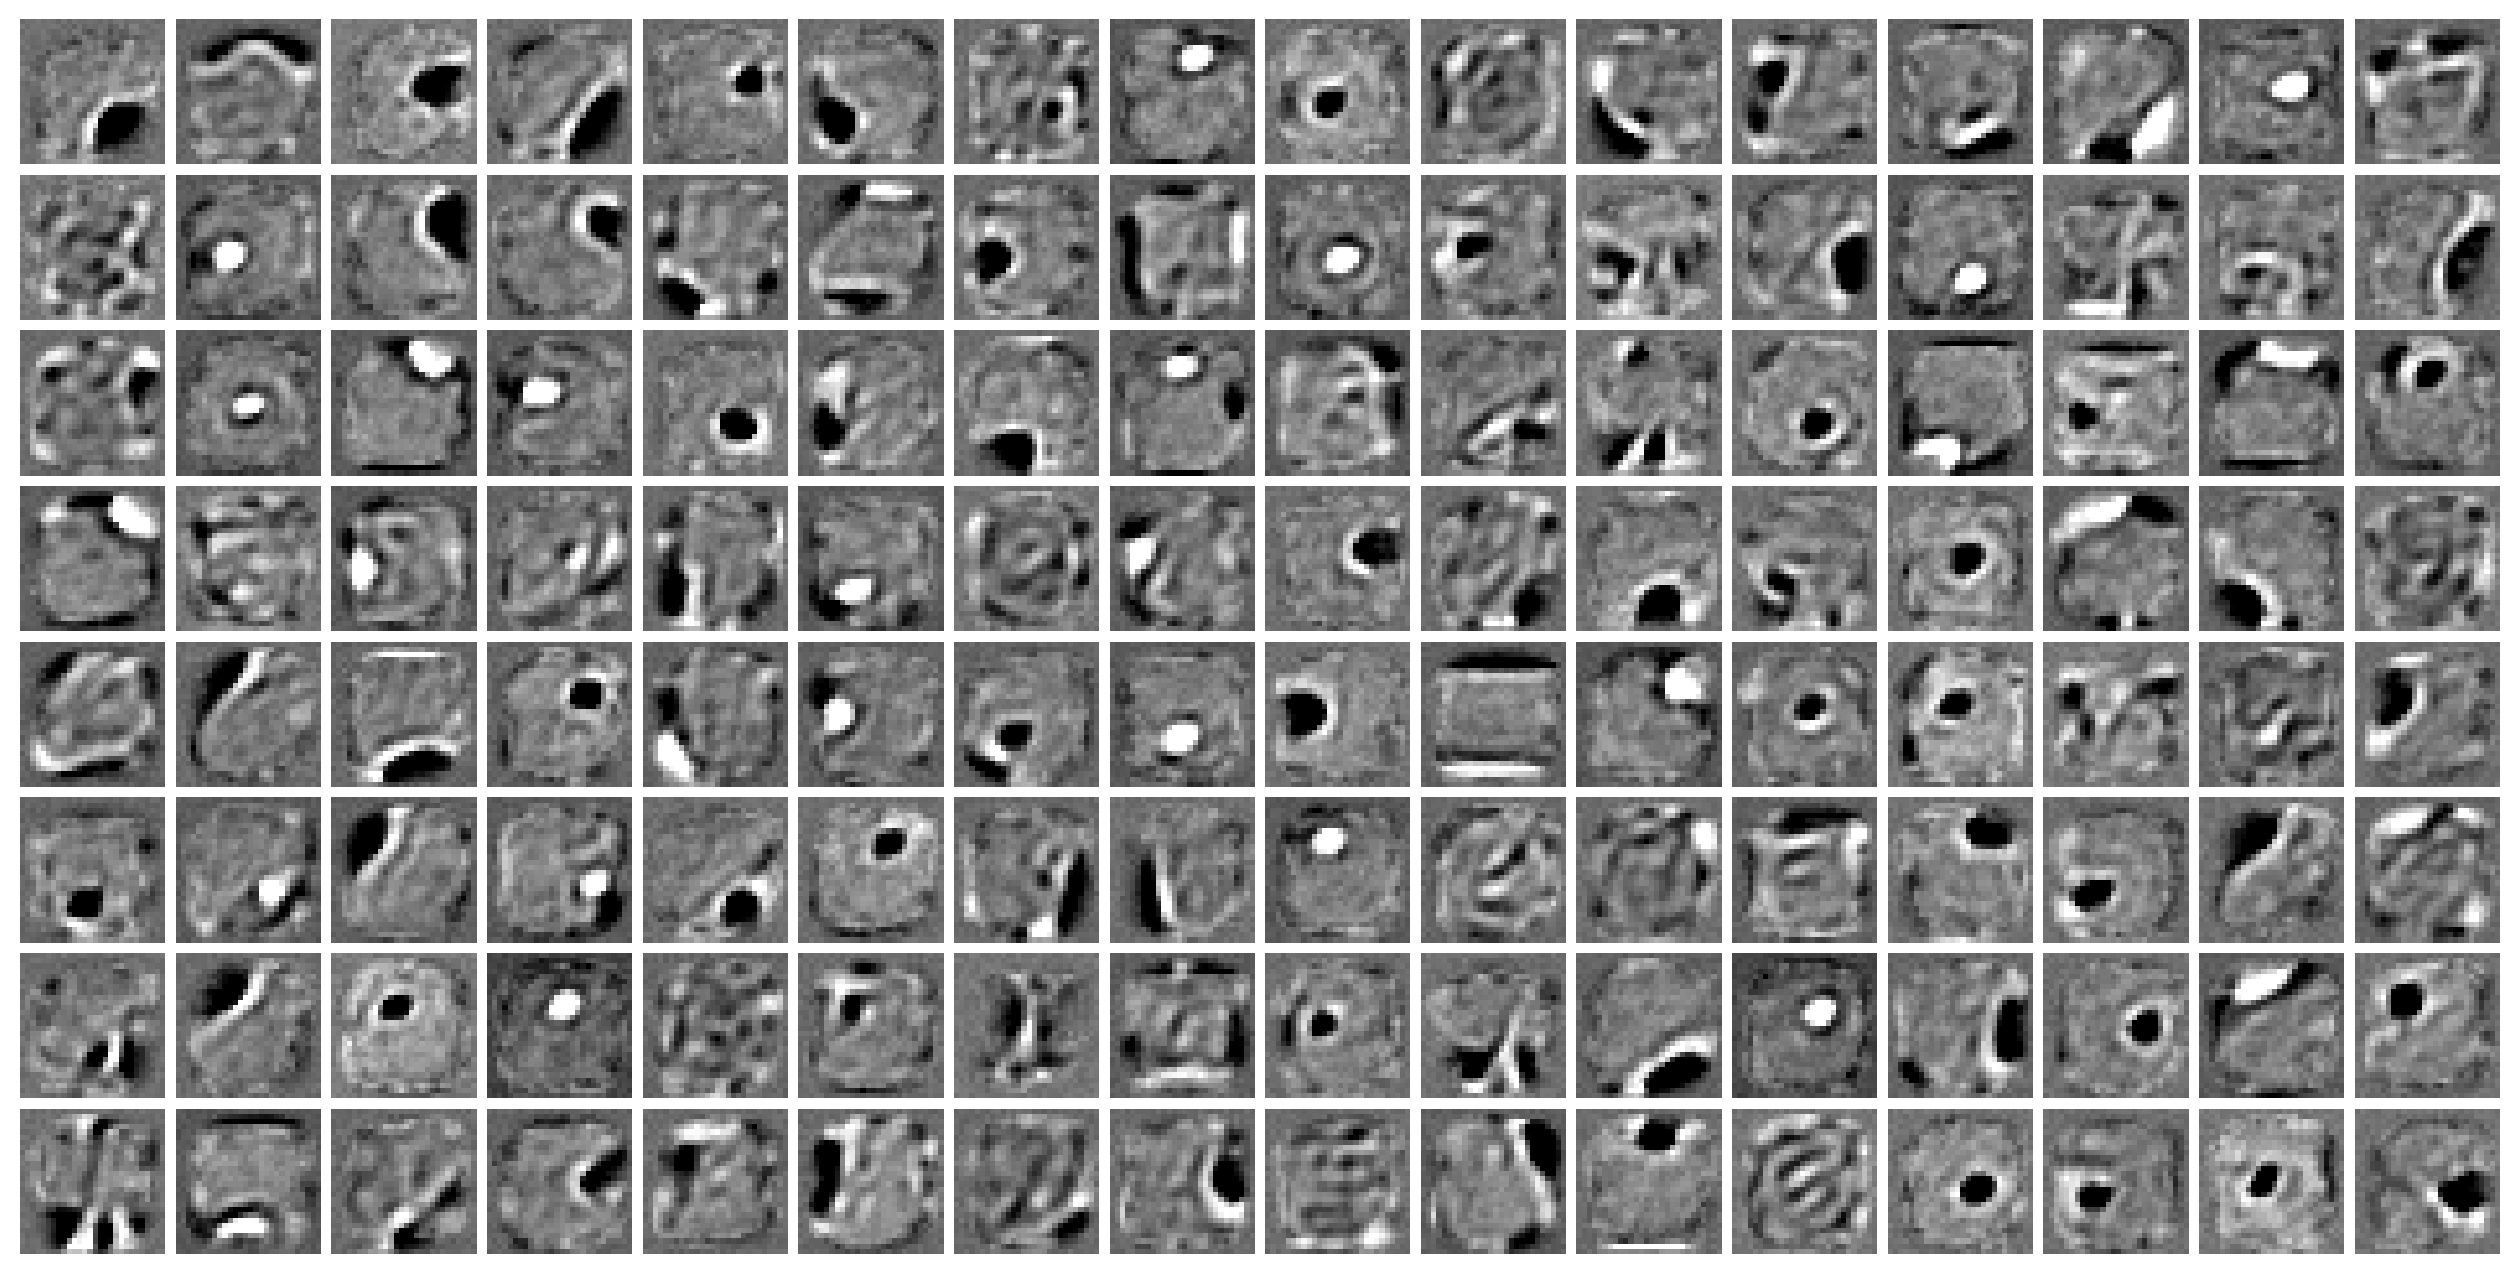

In [10]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.1
MOMENTUM = 0.5

rbm = RBM(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM)
draw_filters(rbm)

run_training(rbm, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT)

draw_filters(rbm)

# 2. DBN Training

In [11]:
def propagate_up(dbn: Sequence[RBM], n_layers: int, v: NDArray) -> NDArray:
    assert 0 <= n_layers < len(dbn)
    for i in range(n_layers):
        v = dbn[i].probas_h(v)
    return v


def propagate_dn(dbn: Sequence[RBM], n_layers: int, h: NDArray) -> NDArray:
    assert 0 <= n_layers < len(dbn)
    for i in reversed(range(n_layers)):
        h = dbn[i].probas_v(h)
    return h

### DBN reconstruction error

In [12]:
def dbn_reconstuction_error(dbn: Sequence[RBM], n_layers: int, minibatch: NDArray) -> float:
    assert 0 <= n_layers < len(dbn)
    visible = propagate_up(dbn, n_layers, minibatch)
    # batch_size = minibatch.shape[0]
    # samples = propagate_dn(dbn, n_layers, samples)
    # return 1 / batch_size * np.sum((minibatch - samples) ** 2)
    return reconstuction_error(dbn[n_layers], visible)

### Sampling in Deep Belief Networks

In [13]:
def sample_rbm(rbm, minibatch, steps):
    observations_count = minibatch.shape[0]

    # BUG: If you are keeping all the parameters in a single matrix `W`, you should COPY the
    # minibatch as the later assignments (that use slicing) MODIFY the input minibatch.
    visible = minibatch  # .copy()
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    for cd_i in range(steps):
        hidden[:, :-1] = sigmoid(visible @ rbm.W[:, :-1])
        hidden[:, :-1] = (hidden[:, :-1] > rand(observations_count, rbm.hidden_size)).astype(np.float32)

        visible[:, :-1] = sigmoid(hidden @ np.transpose(rbm.W[:-1, :]))
        if cd_i < (steps - 1):
            visible[:, :-1] = (visible[:, :-1] > rand(observations_count, rbm.visible_size)).astype(np.float32)

    return visible

In [14]:
def sample_dbn(dbn: Sequence[RBM], layer_idx: int, minibatch: NDArray, steps: int) -> NDArray:
    visible = propagate_up(dbn, layer_idx, minibatch)
    samples = dbn[layer_idx].sample(visible, steps)
    samples = propagate_dn(dbn, layer_idx, samples)
    return samples

In [15]:
def draw_layer_samples(dbn: Sequence[RBM], layer_idx: int, minibatch: NDArray, steps: int = 200):
    samples = sample_dbn(dbn, layer_idx, minibatch, steps)
    samples = samples.reshape(-1, 16, 28, 28)
    tiles(samples)

### Greedy layer-wise training

In [16]:
def train_dbn(dbn: Sequence[RBM], layer_idx: int, dataset: NDArray, batch_size: int):
    dataset = propagate_up(dbn, layer_idx, dataset)
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(dbn[layer_idx], batch)
        if batch_idx % round(batches_limit / 50) == 0:
            print("#", end="")

In [17]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.1
MOMENTUM = 0.5

DBN_HIDDEN_LAYER_SIZE = 200
dbn = [
    RBM(VISIBLE_LAYER_SIZE, DBN_HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM),
    RBM(DBN_HIDDEN_LAYER_SIZE, DBN_HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM),
    RBM(DBN_HIDDEN_LAYER_SIZE, DBN_HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM),
]

for layer_idx in range(len(dbn)):
    print("\nLearning layer {}".format(layer_idx))

    for epoch in range(EPOCHS_COUNT):
        print("Epoch {}:".format(epoch), end="\t")

        if epoch == 5:
            dbn[layer_idx].momentum = 0.8

        start_time = time.time()
        train_dbn(dbn, layer_idx, dataset, BATCH_SIZE)
        elapsed = time.time() - start_time

        error = dbn_reconstuction_error(dbn, layer_idx, monitoring_set)
        print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

print("Training finished!")


Learning layer 0
Epoch 0:	#####################################################	elapsed: 0.68s, reconstruction error: 22.14
Epoch 1:	#####################################################	elapsed: 0.59s, reconstruction error: 18.16
Epoch 2:	#####################################################	elapsed: 0.78s, reconstruction error: 16.10
Epoch 3:	#####################################################	elapsed: 0.41s, reconstruction error: 14.65
Epoch 4:	#####################################################	elapsed: 0.48s, reconstruction error: 13.78
Epoch 5:	#####################################################	elapsed: 0.68s, reconstruction error: 12.97
Epoch 6:	#####################################################	elapsed: 0.65s, reconstruction error: 11.80
Epoch 7:	#####################################################	elapsed: 0.44s, reconstruction error: 11.21
Epoch 8:	#####################################################	elapsed: 0.52s, reconstruction error: 10.69
Epoch 9:	##########

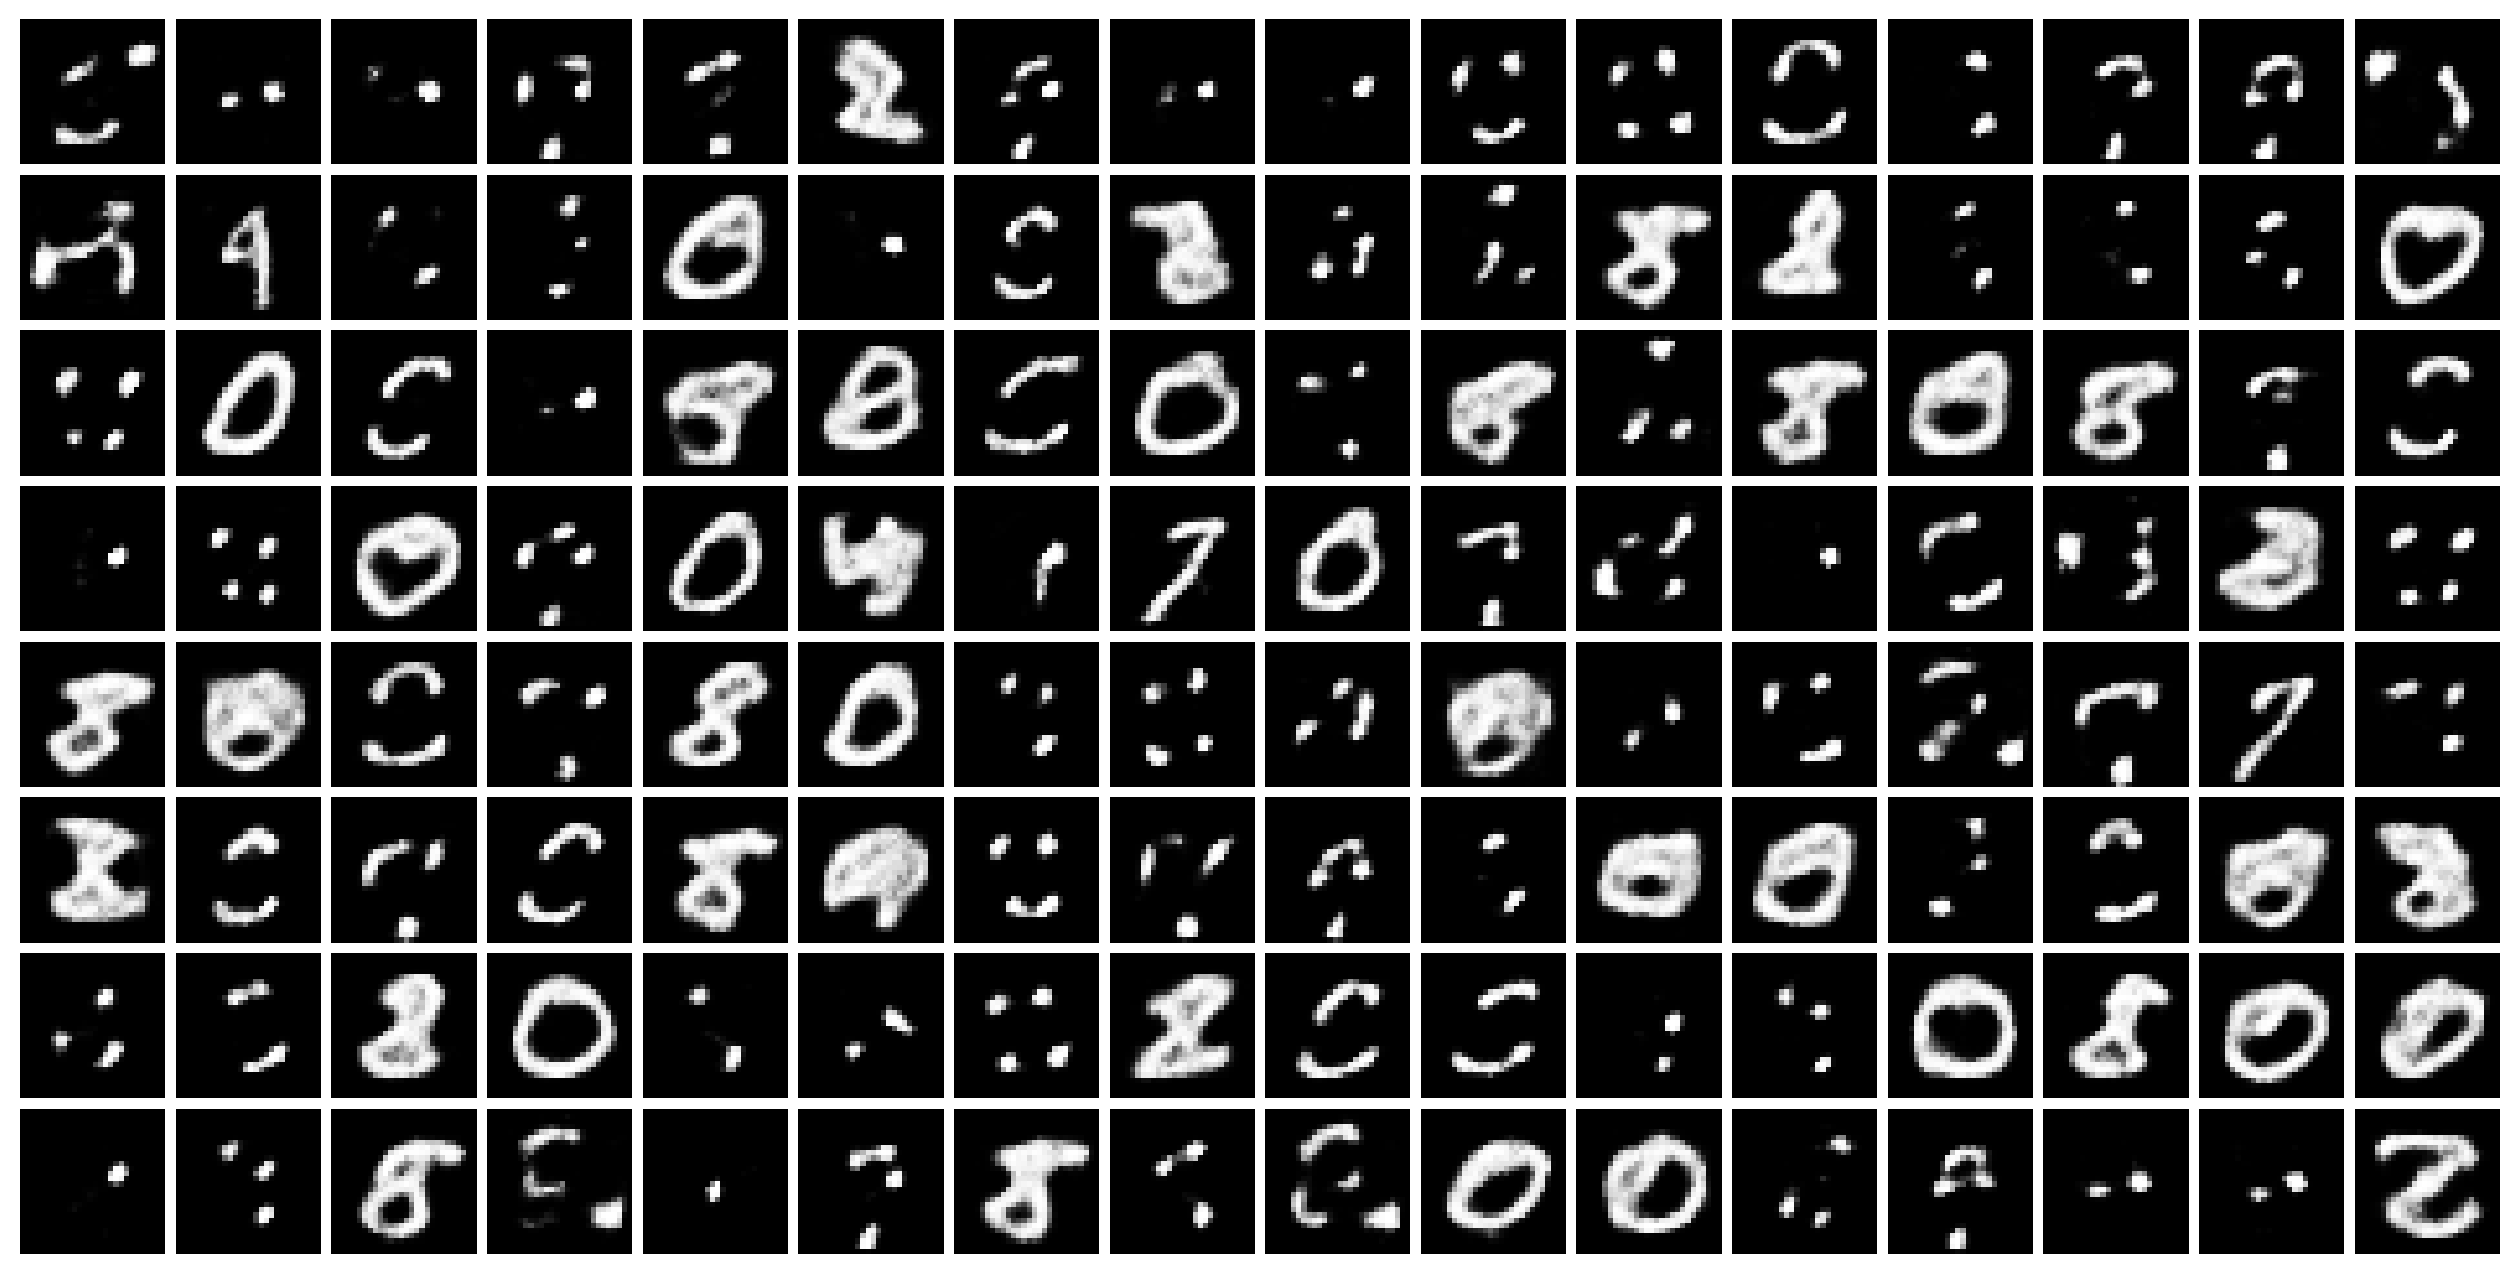

In [18]:
draw_layer_samples(dbn, 0, monitoring_set[: 8 * 16])

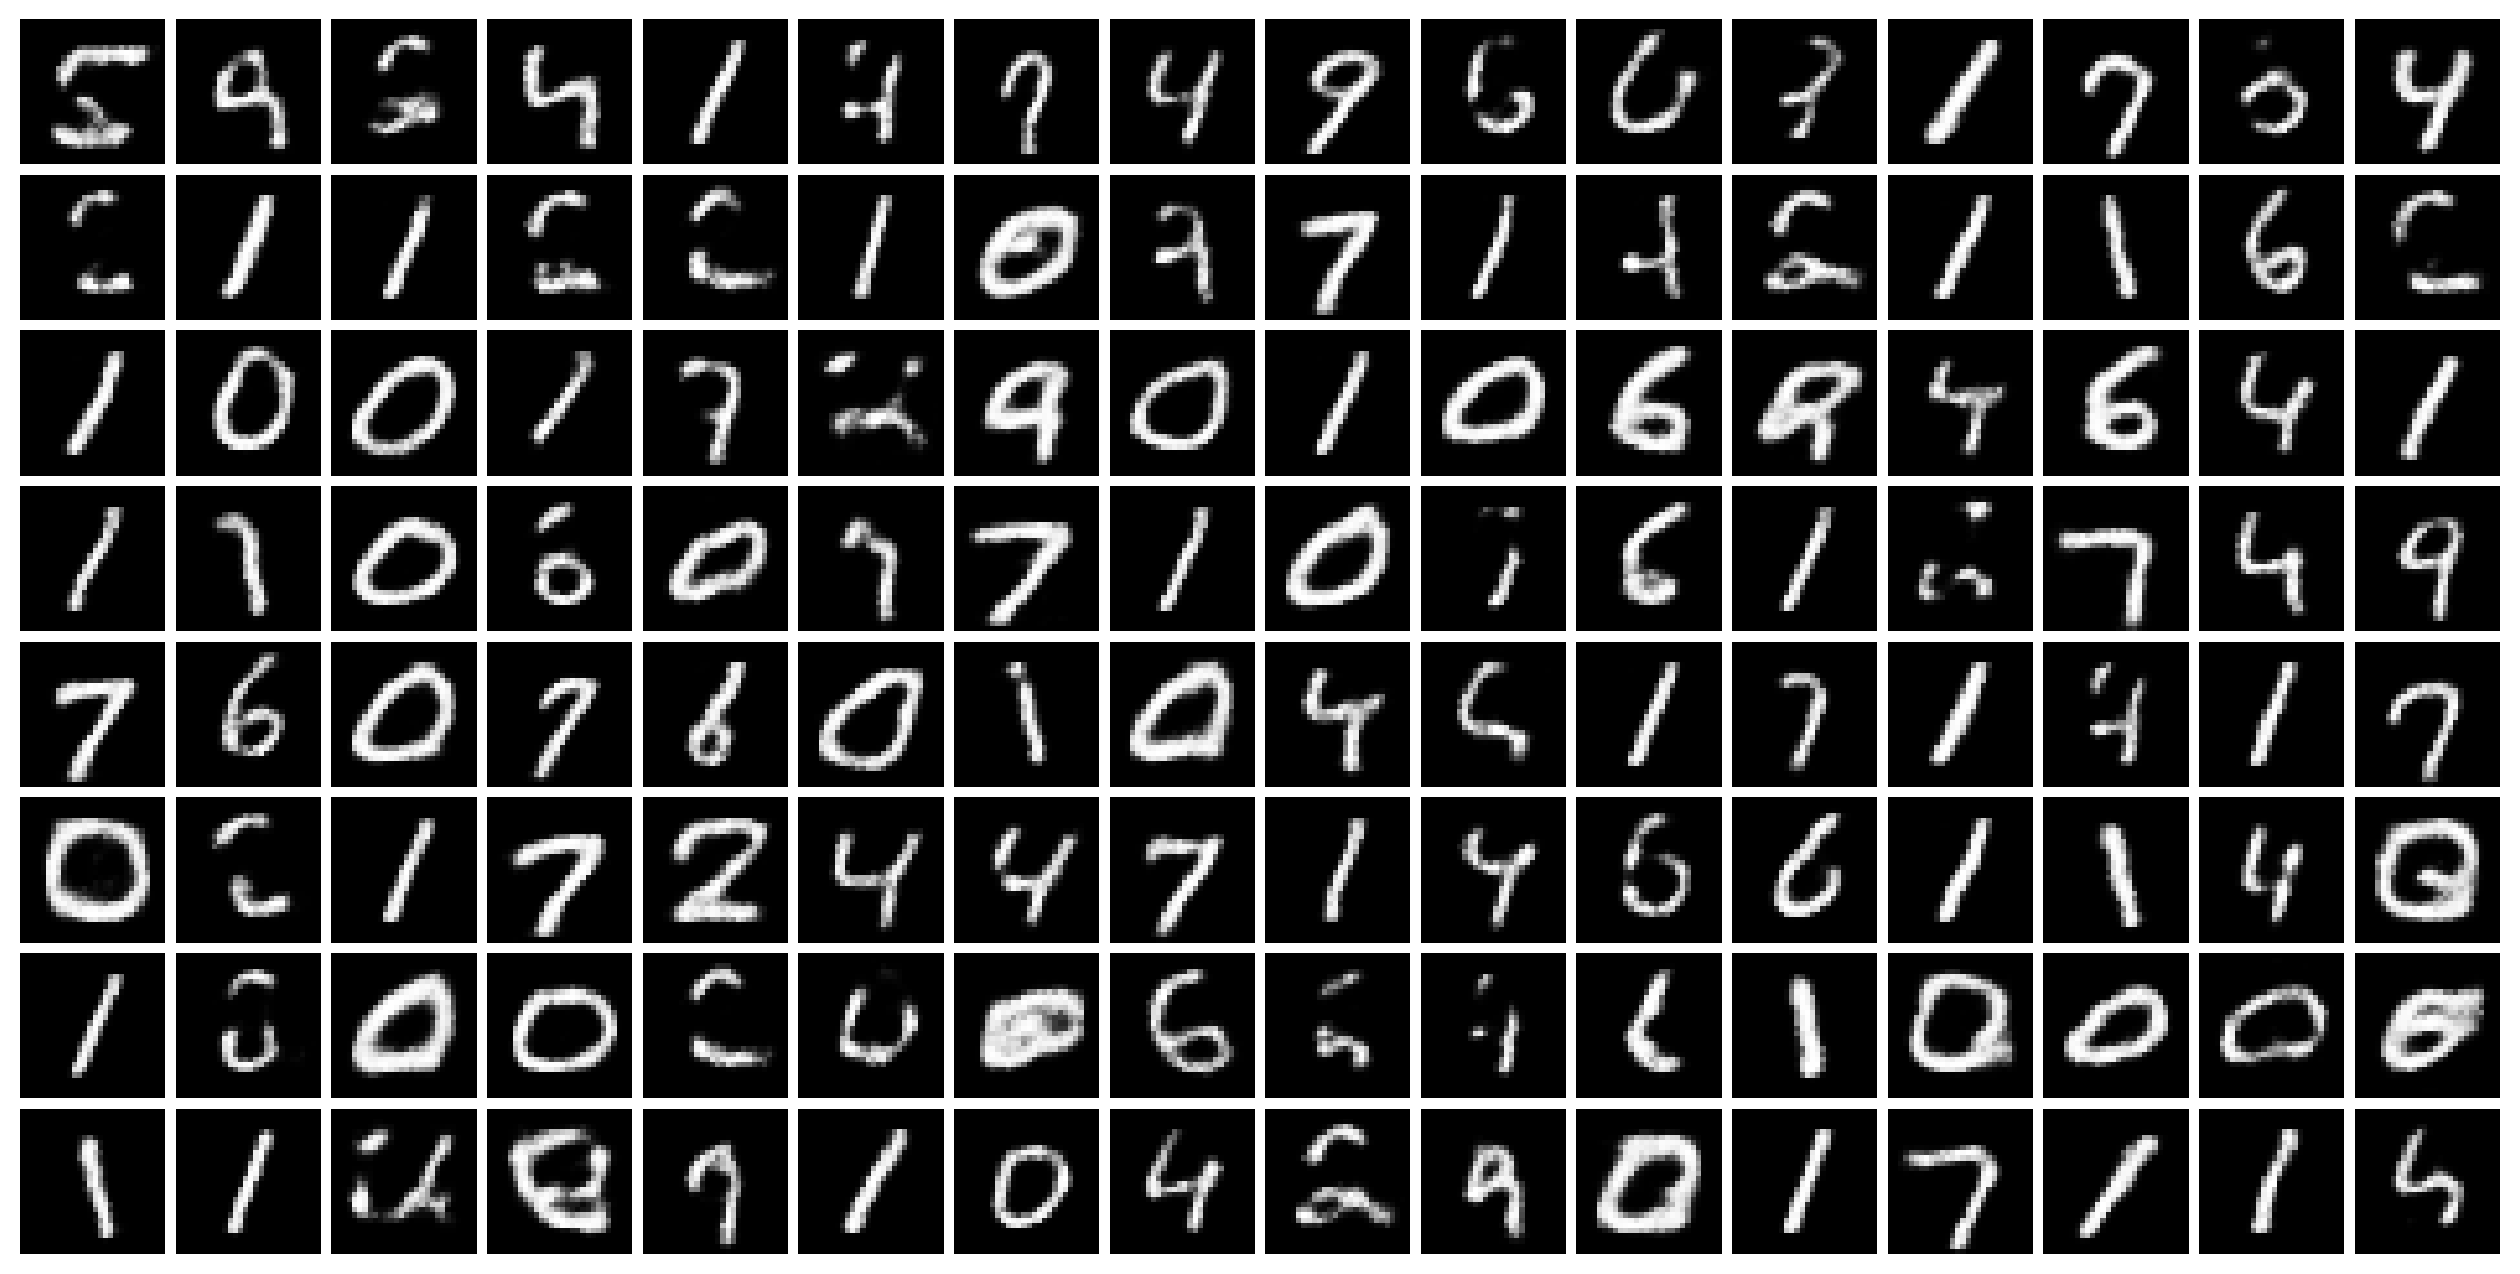

In [19]:
draw_layer_samples(dbn, 1, monitoring_set[: 8 * 16])

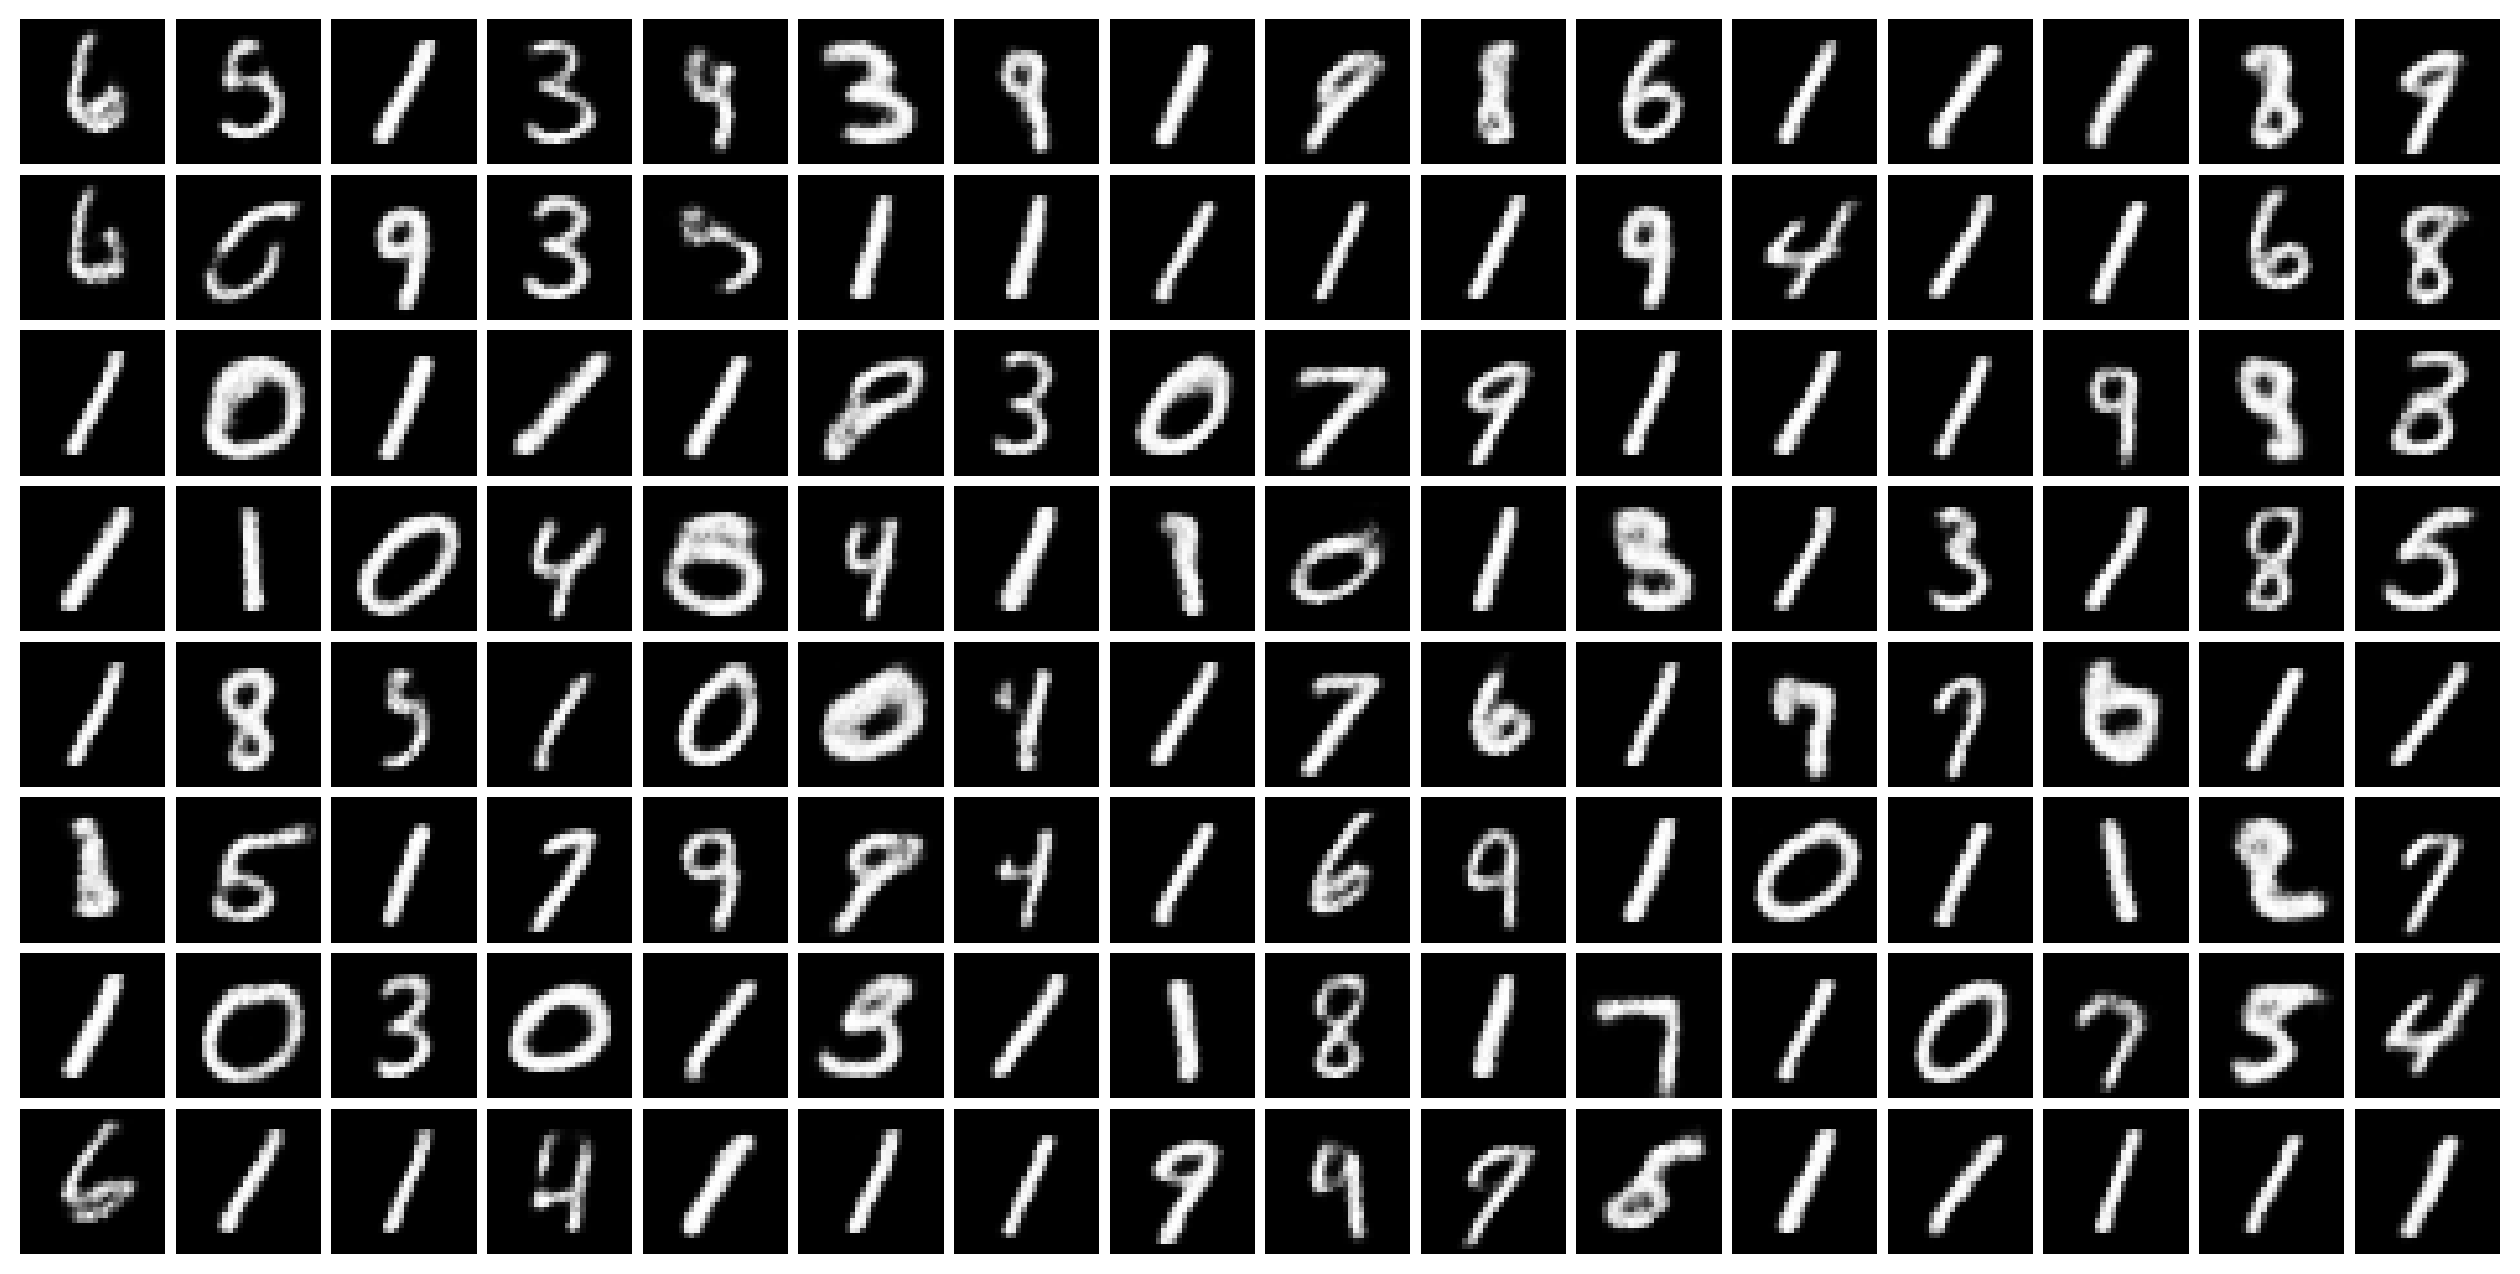

In [20]:
draw_layer_samples(dbn, 2, monitoring_set[: 8 * 16])